<a href="https://colab.research.google.com/github/pierce3215/finances/blob/main/Intraday_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
from pandas import read_csv
import ta
import requests
import io
import numpy as np
import seaborn as sns
from datetime import date
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [45]:
def fetch_intraday_data(symbol, interval, api_key):
    base_url = "https://www.alphavantage.co/query"
    function = "TIME_SERIES_INTRADAY"
    datatype = "csv"

    params = {
        "function": function,
        "symbol": symbol,
        "interval": interval,
        "apikey": api_key,
        "datatype": datatype,
        "outputsize": "full"
    }

    response = requests.get(base_url, params=params)
    csv_string = response.text
    df = pd.read_csv(io.StringIO(csv_string))
    return df

data = fetch_intraday_data("SPY", "5min", "EV7ES0KENKPGV3GF")

In [46]:
data.head()

,timestamp,open,high,low,close,volume
0,2023-10-09 20:00:00,432.290,432.29,432.29,432.290,1503899
1,2023-10-09 19:55:00,432.220,432.30,432.22,432.278,9067
2,2023-10-09 19:50:00,432.160,432.26,432.16,432.230,5606
3,2023-10-09 19:45:00,432.145,432.20,432.14,432.170,883
4,2023-10-09 19:40:00,432.230,432.23,432.12,432.145,4346


In [47]:
data.tail()

,timestamp,open,high,low,close,volume
3083,2023-09-18 04:20:00,443.92,444.02,443.91,443.91,2792
3084,2023-09-18 04:15:00,444.11,444.11,443.92,443.93,3210
3085,2023-09-18 04:10:00,444.11,444.15,444.03,444.11,1362
3086,2023-09-18 04:05:00,444.02,444.10,443.96,444.08,3033
3087,2023-09-18 04:00:00,444.00,444.18,443.81,444.05,6443


In [48]:
data = data.iloc[::-1].reset_index(drop=True)

In [49]:
data.head()

,timestamp,open,high,low,close,volume
0,2023-09-18 04:00:00,444.00,444.18,443.81,444.05,6443
1,2023-09-18 04:05:00,444.02,444.10,443.96,444.08,3033
2,2023-09-18 04:10:00,444.11,444.15,444.03,444.11,1362
3,2023-09-18 04:15:00,444.11,444.11,443.92,443.93,3210
4,2023-09-18 04:20:00,443.92,444.02,443.91,443.91,2792


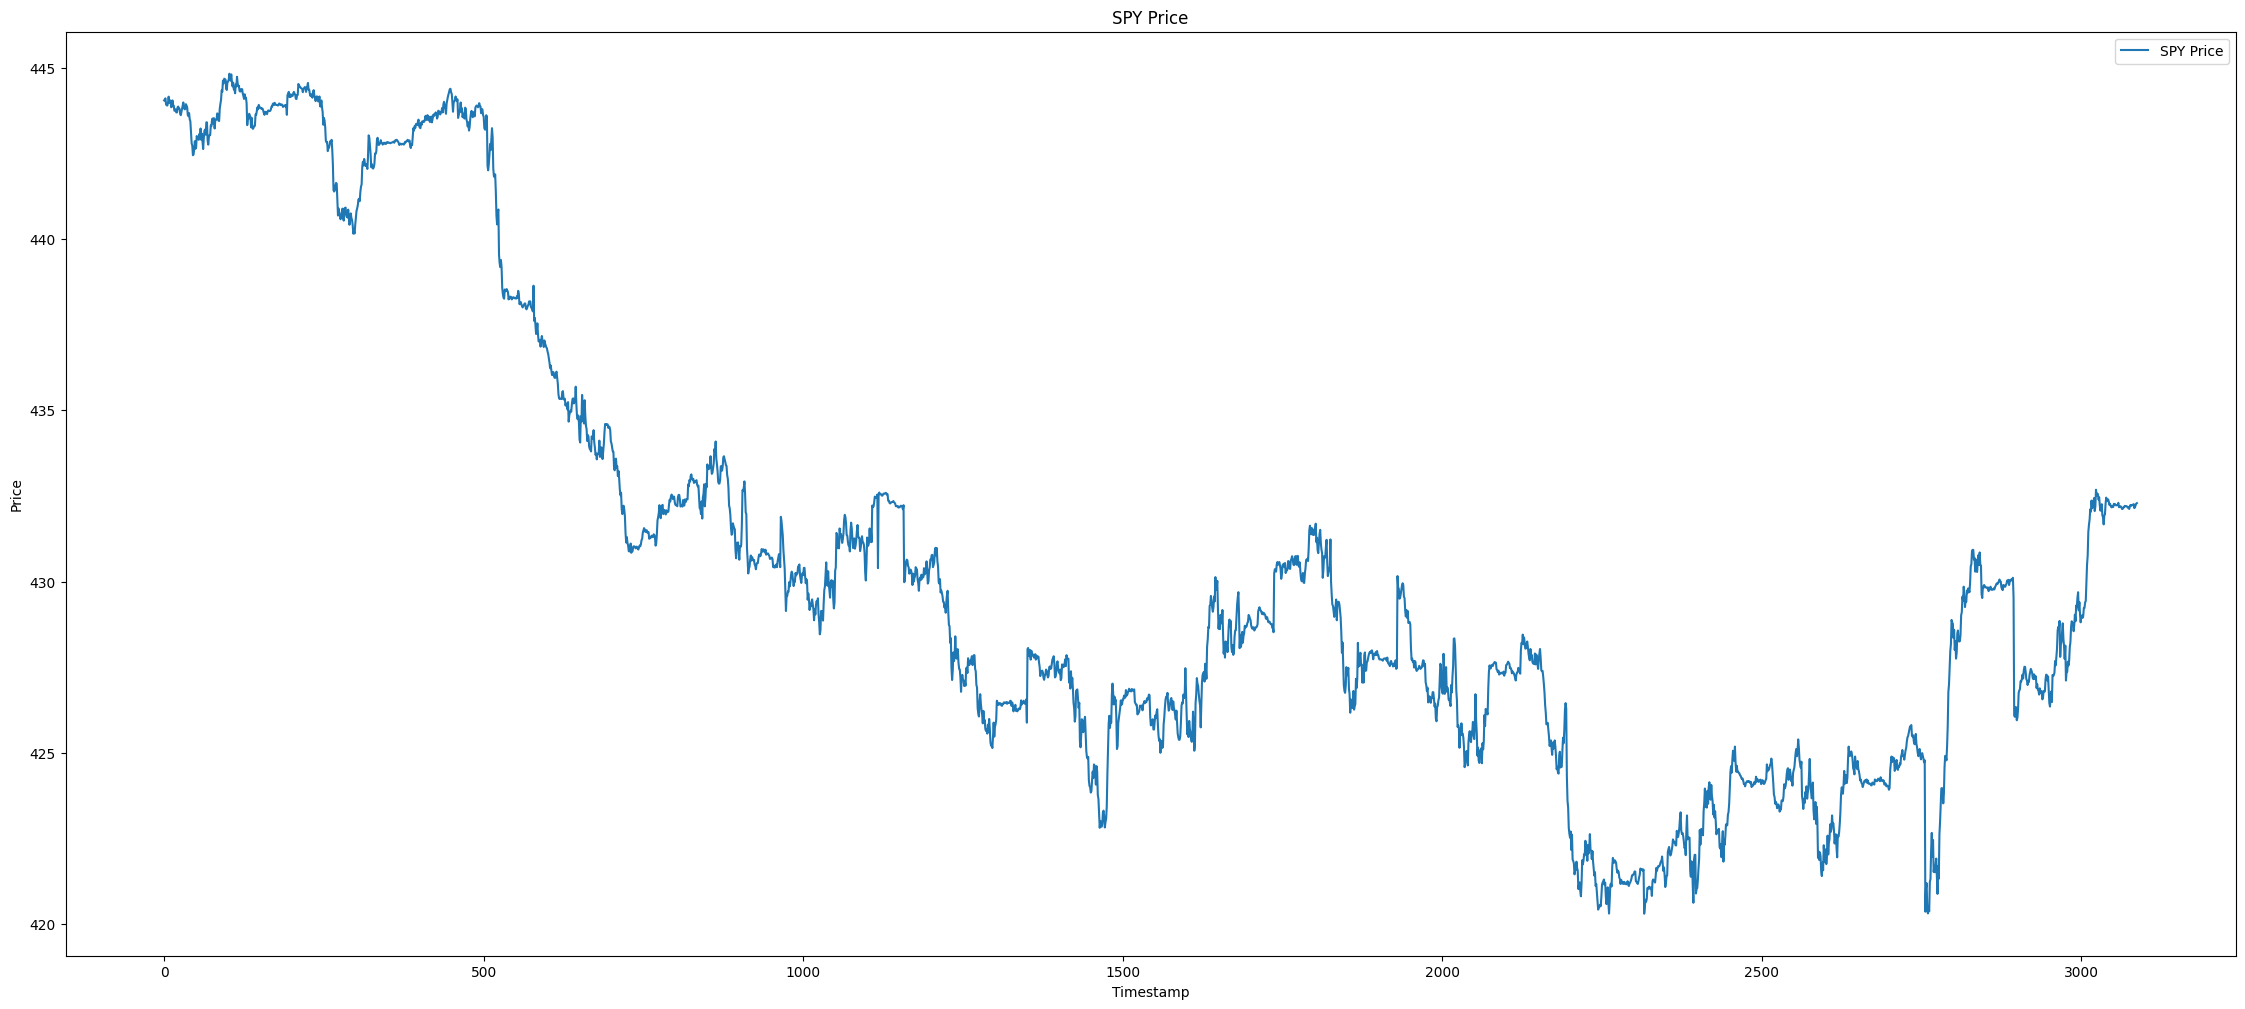

In [50]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['close'], label='SPY Price')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('SPY Price')
plt.legend()
plt.show()

In [62]:
from ta.momentum import RSIIndicator

In [63]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['close'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create RSI
    rsi_ind = RSIIndicator(dataset['close'])
    dataset['RSI'] = rsi_ind.rsi()

    # Create Bollinger Bands
    dataset['20sd'] = dataset['close'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [64]:
df = get_technical_indicators(data)

In [65]:
df = df.dropna()
df.head()

,timestamp,open,high,low,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,RSI
20,2023-09-18 05:40:00,443.73,443.75,443.68,443.70,438,443.784286,443.923810,443.875719,443.825131,-0.050588,0.134554,444.192917,443.654702,443.709179,442.70,6.092892,36.074343
21,2023-09-18 05:45:00,443.70,443.87,443.70,443.85,618,443.777143,443.914286,443.873384,443.829056,-0.044328,0.132234,444.178753,443.649819,443.803060,442.85,6.093231,46.520709
22,2023-09-18 05:50:00,443.84,443.87,443.73,443.87,966,443.772857,443.904286,443.873082,443.835493,-0.037589,0.126908,444.158102,443.650469,443.847687,442.87,6.093276,47.746810
23,2023-09-18 05:55:00,443.83,443.83,443.81,443.81,561,443.781429,443.890000,443.867534,443.831499,-0.036035,0.119248,444.128495,443.651505,443.822562,442.81,6.093141,44.454065
24,2023-09-18 06:00:00,443.79,443.90,443.79,443.81,81,443.790000,443.884286,443.862544,443.828140,-0.034404,0.120107,444.124500,443.644072,443.814187,442.81,6.093141,44.454065


In [73]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for SPY - last {} periods.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

   # Plot third subplot

    plt.subplot(2, 1, 2)
    plt.title('RSI')
    plt.plot(dataset['RSI'],label='RSI', linestyle='-.')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

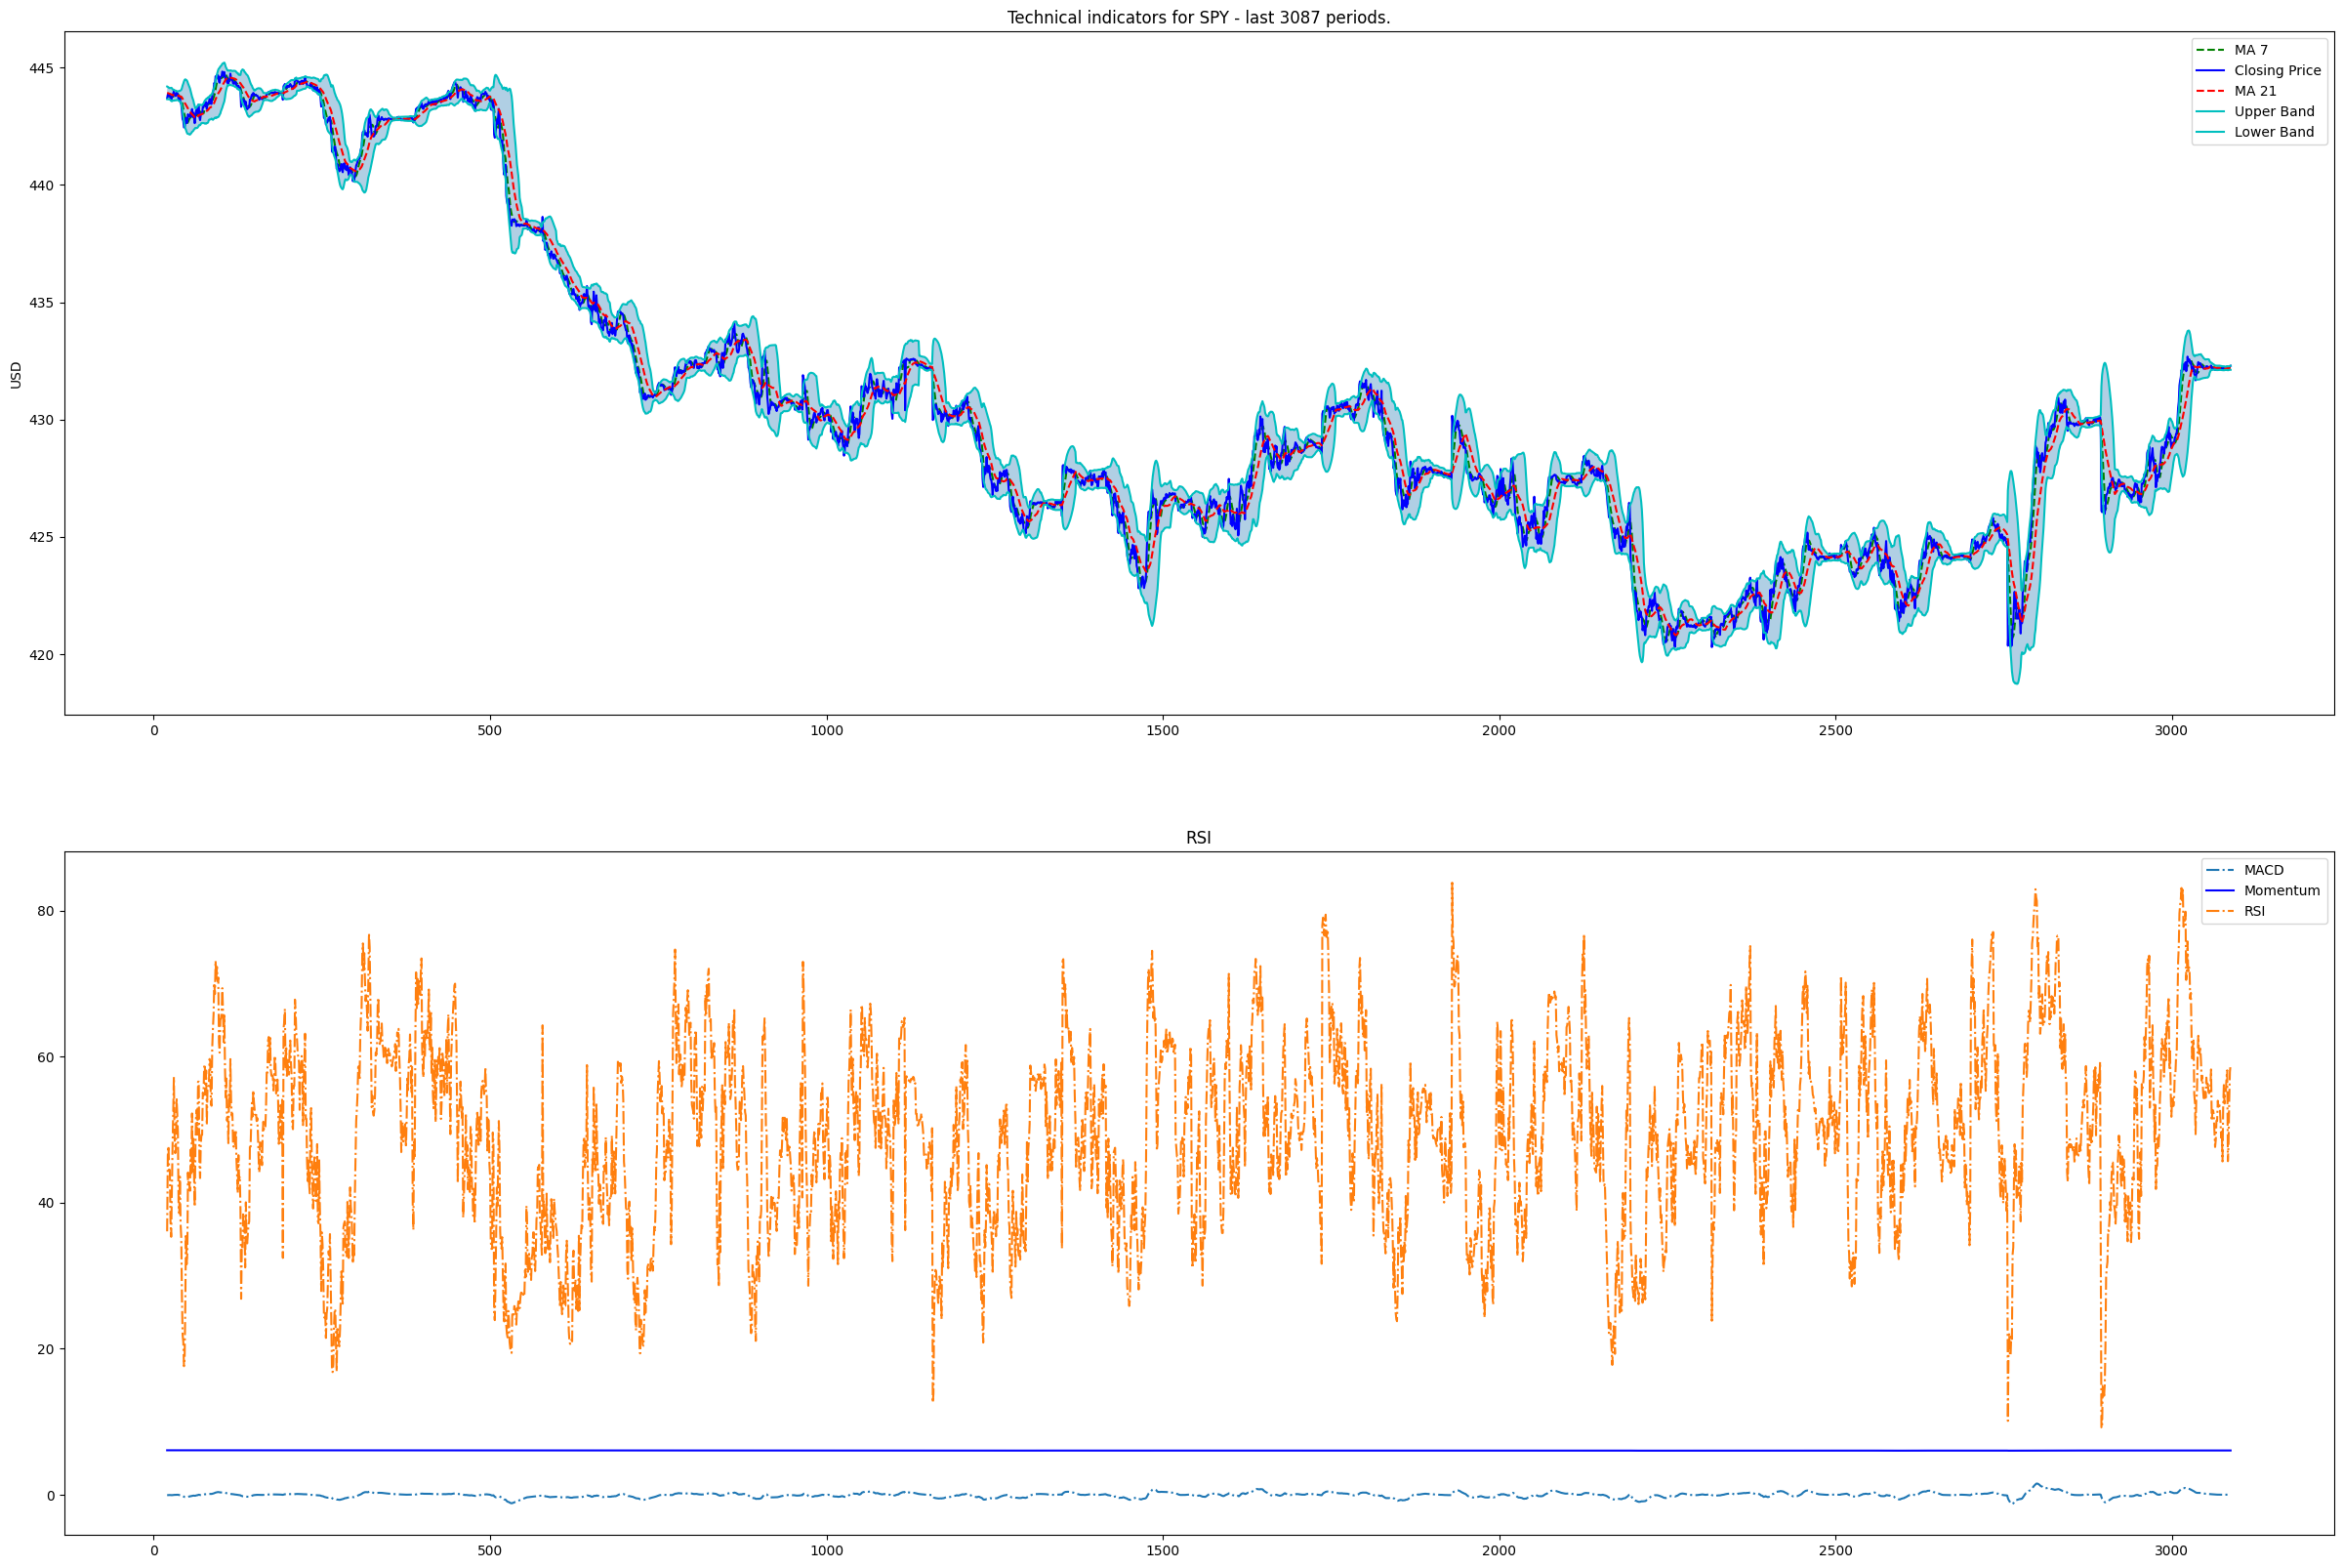

In [74]:
plot_technical_indicators(df, 3087)

<ipython-input-75-8651ef11eb46>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True).set_title('Params')


Text(0.5, 1.0, 'Params')

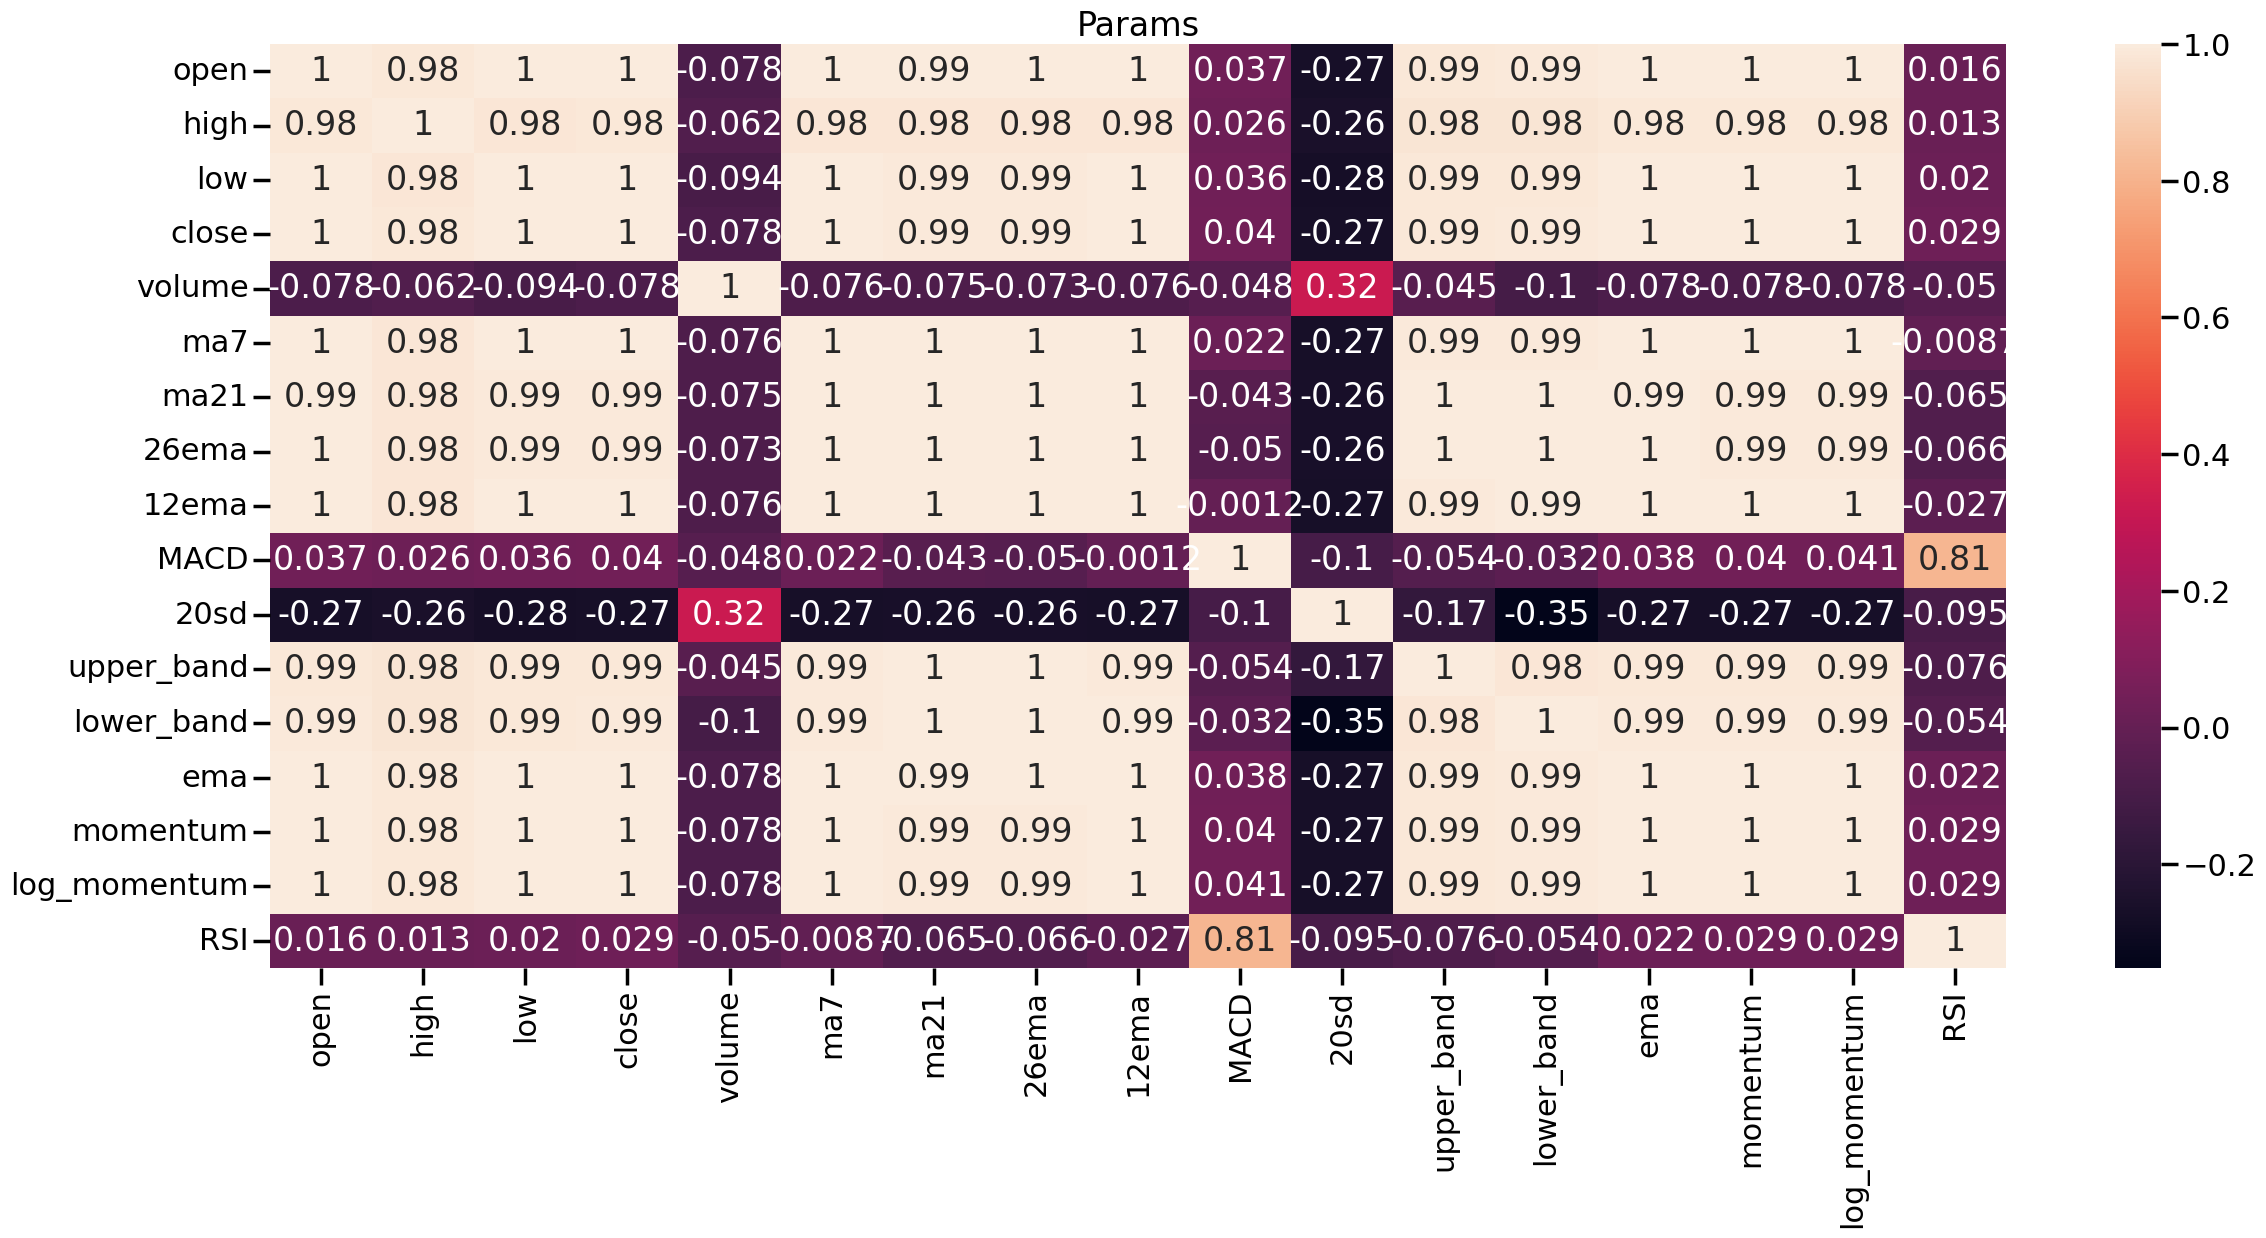

In [75]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')

In [76]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3068 samples, and 18 features.


In [77]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'ma7', 'ma21',
       '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema',
       'momentum', 'log_momentum', 'RSI'],
      dtype='object')

In [78]:
df

,timestamp,open,high,low,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,RSI
20,2023-09-18 05:40:00,443.730,443.75,443.68,443.700,438,443.784286,443.923810,443.875719,443.825131,-0.050588,0.134554,444.192917,443.654702,443.709179,442.700,6.092892,36.074343
21,2023-09-18 05:45:00,443.700,443.87,443.70,443.850,618,443.777143,443.914286,443.873384,443.829056,-0.044328,0.132234,444.178753,443.649819,443.803060,442.850,6.093231,46.520709
22,2023-09-18 05:50:00,443.840,443.87,443.73,443.870,966,443.772857,443.904286,443.873082,443.835493,-0.037589,0.126908,444.158102,443.650469,443.847687,442.870,6.093276,47.746810
23,2023-09-18 05:55:00,443.830,443.83,443.81,443.810,561,443.781429,443.890000,443.867534,443.831499,-0.036035,0.119248,444.128495,443.651505,443.822562,442.810,6.093141,44.454065
24,2023-09-18 06:00:00,443.790,443.90,443.79,443.810,81,443.790000,443.884286,443.862544,443.828140,-0.034404,0.120107,444.124500,443.644072,443.814187,442.810,6.093141,44.454065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,2023-10-09 19:40:00,432.230,432.23,432.12,432.145,4346,432.222857,432.187143,432.190678,432.205200,0.014523,0.042059,432.271260,432.103026,432.181408,431.145,6.066444,45.686544
3084,2023-10-09 19:45:00,432.145,432.20,432.14,432.170,883,432.213571,432.188095,432.189146,432.199785,0.010639,0.041397,432.270889,432.105302,432.173803,431.170,6.066502,48.277507
3085,2023-10-09 19:50:00,432.160,432.26,432.16,432.230,5606,432.216429,432.193571,432.192172,432.204433,0.012261,0.038767,432.271105,432.116038,432.211268,431.230,6.066642,53.954716
3086,2023-10-09 19:55:00,432.220,432.30,432.22,432.278,9067,432.223286,432.200619,432.198530,432.215751,0.017222,0.040063,432.280745,432.120493,432.255756,431.278,6.066753,57.932798


In [82]:
data_training = df[df.index < 1500].copy()
data_training

,timestamp,open,high,low,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,RSI
20,2023-09-18 05:40:00,443.73,443.75,443.68,443.70,438,443.784286,443.923810,443.875719,443.825131,-0.050588,0.134554,444.192917,443.654702,443.709179,442.70,6.092892,36.074343
21,2023-09-18 05:45:00,443.70,443.87,443.70,443.85,618,443.777143,443.914286,443.873384,443.829056,-0.044328,0.132234,444.178753,443.649819,443.803060,442.85,6.093231,46.520709
22,2023-09-18 05:50:00,443.84,443.87,443.73,443.87,966,443.772857,443.904286,443.873082,443.835493,-0.037589,0.126908,444.158102,443.650469,443.847687,442.87,6.093276,47.746810
23,2023-09-18 05:55:00,443.83,443.83,443.81,443.81,561,443.781429,443.890000,443.867534,443.831499,-0.036035,0.119248,444.128495,443.651505,443.822562,442.81,6.093141,44.454065
24,2023-09-18 06:00:00,443.79,443.90,443.79,443.81,81,443.790000,443.884286,443.862544,443.828140,-0.034404,0.120107,444.124500,443.644072,443.814187,442.81,6.093141,44.454065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2023-09-27 16:00:00,426.02,426.43,425.92,426.16,2876635,425.843714,425.873143,425.518751,425.901277,0.382527,0.851386,427.575914,424.170372,426.074564,425.16,6.052466,57.649597
1496,2023-09-27 16:05:00,426.13,426.35,425.75,426.31,6883450,425.809429,426.010524,425.577362,425.964158,0.386796,0.644137,427.298797,424.722250,426.231521,425.31,6.052818,59.066070
1497,2023-09-27 16:10:00,426.05,426.60,426.05,426.53,1154261,425.883571,426.112905,425.647928,426.051210,0.403283,0.533356,427.179617,425.046193,426.430507,425.53,6.053335,61.120034
1498,2023-09-27 16:15:00,426.53,427.00,423.20,426.40,672583,426.067857,426.173381,425.703637,426.104870,0.401234,0.486256,427.145892,425.200870,426.410169,425.40,6.053030,59.228790


In [83]:
data_testing = df[df.index > 1500].copy()
data_testing

,timestamp,open,high,low,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,RSI
1501,2023-09-27 16:30:00,426.550,426.67,426.54,426.560,34564,426.420714,426.263381,425.871592,426.269300,0.397708,0.479865,427.223111,425.303651,426.543710,425.560,6.053406,60.935250
1502,2023-09-27 16:35:00,426.550,426.67,426.53,426.670,21380,426.493571,426.297667,425.930734,426.330946,0.400213,0.482071,427.261809,425.333524,426.627903,425.670,6.053664,62.210384
1503,2023-09-27 16:40:00,426.650,426.68,426.59,426.620,30446,426.537857,426.332905,425.981790,426.375416,0.393626,0.477034,427.286973,425.378836,426.622634,425.620,6.053547,61.231996
1504,2023-09-27 16:45:00,426.620,426.65,426.58,426.610,11762,426.549286,426.329095,426.028325,426.411506,0.383181,0.474352,427.277799,425.380392,426.614211,425.610,6.053523,61.025281
1505,2023-09-27 16:50:00,426.615,426.85,426.59,426.830,118071,426.610714,426.320048,426.087708,426.475890,0.388182,0.462170,427.244389,425.395707,426.758070,425.830,6.054040,63.911754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,2023-10-09 19:40:00,432.230,432.23,432.12,432.145,4346,432.222857,432.187143,432.190678,432.205200,0.014523,0.042059,432.271260,432.103026,432.181408,431.145,6.066444,45.686544
3084,2023-10-09 19:45:00,432.145,432.20,432.14,432.170,883,432.213571,432.188095,432.189146,432.199785,0.010639,0.041397,432.270889,432.105302,432.173803,431.170,6.066502,48.277507
3085,2023-10-09 19:50:00,432.160,432.26,432.16,432.230,5606,432.216429,432.193571,432.192172,432.204433,0.012261,0.038767,432.271105,432.116038,432.211268,431.230,6.066642,53.954716
3086,2023-10-09 19:55:00,432.220,432.30,432.22,432.278,9067,432.223286,432.200619,432.198530,432.215751,0.017222,0.040063,432.280745,432.120493,432.255756,431.278,6.066753,57.932798


In [85]:
scalar = MinMaxScaler()

data_training_numeric = data_training.select_dtypes(include=['float64', 'int64'])
data_training_scaled = scalar.fit_transform(data_training_numeric)
print(data_training_scaled.shape)
data_training_scaled

(1480, 17)


array([[0.93370807, 0.5259194 , 0.95363353, ..., 0.94868535, 0.94990535,
        0.36492712],
       [0.93236974, 0.52894207, 0.95452519, ..., 0.95549703, 0.95656244,
        0.52748314],
       [0.93861527, 0.52894207, 0.95586268, ..., 0.95640525, 0.95744988,
        0.54656251],
       ...,
       [0.14498572, 0.09392947, 0.16763263, ..., 0.16897507, 0.17258829,
        0.75466343],
       [0.166399  , 0.10400504, 0.04057066, ..., 0.16307161, 0.16658409,
        0.72523376],
       [0.14498572, 0.49972292, 0.16763263, ..., 0.16443395, 0.16796984,
        0.73007538]])

In [86]:
X_train = []
y_train = []

In [87]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [88]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1420, 60, 17), (1420,))

In [89]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [90]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            12600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [91]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [94]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(60, 17)))
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

RuntimeError: ignored

In [ ]:
past_60 = data_training.tail(60)

dt = past_60.append(data_testing, ignore_index = True)
dt

In [ ]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
y_pred

In [ ]:
scale = 1/scalar.scale_[0]

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()